# Simulation example with *thztools*

In [1]:
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

import numpy as np
from numpy import pi
from numpy.fft import rfftfreq, rfft, irfft
from numpy.random import default_rng

import scipy.linalg as la
from scipy import signal
import scipy.optimize as opt
from scipy import stats

import thztools as thz
from thztools.thztools import _costfuntls

## Simulate noisy terahertz time-domain waveforms

Functions from `thztools`: `thzgen`, `noiseamp`

The first cell below sets the parameters for the simulation, and the subsequent cell generates `n_sim = 11` noisy terahertz time-domain waveforms, each with `n = 256` samples, and stores them in an `(n_sim, n)` NumPy array `x`. The function `thzgen` returns discrete samples `mu` of an ideal waveform evaluated at the measurement times `t`. The function `noiseamp` returns the noise amplitude `sigma` at each point in the sampled waveform. We use the SciPy `periodogram` function to compute the power spectral density `psd` of each noisy waveform in `x` at the discrete frequencies `f`.

The next cell generates a figure that shows (a) `mu` and `30 * sigma` as a function of `t`; and (b) `psd` as a function of `f`, normalized to the maximum value over the set.

In [2]:
n = 256  # Number of samples
m = 10  # Number of waveforms
dt = 0.05  # Sampling time [ps]

sigma_alpha = 1e-5  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
noise_model = thz.NoiseModel(sigma_alpha, sigma_beta, sigma_tau)

seed = 0  # RNG seed
rng = default_rng(seed)

In [3]:
thz.global_options.sampling_time = dt
t = thz.timebase(n)
mu = thz.wave(n)
sigma = noise_model.amplitude(mu)

# Use broadcasting to generate multiple simulated noisy measurements of mu
n_sim = 1000

In [4]:
%%time

sigma_alpha_est = np.zeros(n_sim)
sigma_alpha_err = np.zeros(n_sim)
sigma_beta_est = np.zeros(n_sim)
sigma_beta_err = np.zeros(n_sim)
sigma_tau_est = np.zeros(n_sim)
sigma_tau_err = np.zeros(n_sim)
mu_est = np.zeros((n, n_sim))
mu_err = np.zeros((n, n_sim))
a_est = np.zeros((m, n_sim))
a_err = np.zeros((m, n_sim))
eta_est = np.zeros((m, n_sim))
eta_err = np.zeros((m, n_sim))
for i in range(n_sim):
    x = mu + noise_model.noise(np.tile(mu, (m, 1)), seed=i)
    fit_result = thz.noisefit(x.T)
    sigma_alpha_est[i] = fit_result.noise_model.sigma_alpha
    sigma_alpha_err[i] = fit_result.err_sigma_alpha
    sigma_beta_est[i] = fit_result.noise_model.sigma_beta
    sigma_beta_err[i] = fit_result.err_sigma_beta
    sigma_tau_est[i] = fit_result.noise_model.sigma_tau
    sigma_tau_err[i] = fit_result.err_sigma_tau
    mu_est[:, i] = fit_result.mu
    mu_err[:, i] = fit_result.err_mu
    a_est[:, i] = fit_result.a
    a_err[:, i] = fit_result.err_a
    eta_est[:, i] = fit_result.eta
    eta_err[:, i] = fit_result.err_eta

sigma_correct = np.sqrt(m / (m - 1))

CPU times: user 1h 24min 29s, sys: 3min 26s, total: 1h 27min 56s
Wall time: 20min 20s


In [5]:
sigma_alpha_est_mean = np.mean(sigma_alpha_est)
sigma_alpha_est_std = np.std(sigma_alpha_est, ddof=1)
sigma_alpha_err_mean = np.mean(sigma_alpha_err)

sigma_beta_est_mean = np.mean(sigma_beta_est)
sigma_beta_est_std = np.std(sigma_beta_est, ddof=1)
sigma_beta_err_mean = np.mean(sigma_beta_err)

sigma_tau_est_mean = np.mean(sigma_tau_est)
sigma_tau_est_std = np.std(sigma_tau_est, ddof=1)
sigma_tau_err_mean = np.mean(sigma_tau_err)

mu_est_mean = np.mean(mu_est, axis=1)
mu_est_std = np.std(mu_est, axis=1, ddof=1)
mu_err_mean = np.mean(mu_err, axis=1)

a_est_mean = np.mean(a_est, axis=1)
a_est_std = np.std(a_est, axis=1)
a_err_mean = np.mean(a_err, axis=1)

eta_est_mean = np.mean(eta_est, axis=1)
eta_est_std = np.std(eta_est, axis=1, ddof=1)
eta_err_mean = np.mean(eta_err, axis=1)

print(f"sigma_alpha: {sigma_alpha_est_mean / sigma_alpha:.4f} "
      f"± {sigma_alpha_est_std / sigma_alpha:.4f}")
print(f"sigma_beta: {sigma_beta_est_mean / sigma_beta:.4f} "
      f"± {sigma_beta_est_std / sigma_beta:.4f}")
print(f"sigma_tau: {sigma_tau_est_mean / sigma_tau:.4f} "
      f"± {sigma_tau_est_std / sigma_tau:.4f}")

np.savez("sim_dump",
         n=n,
         m=m,
         dt=dt,
         sigma_alpha=sigma_alpha,
         sigma_beta=sigma_beta,
         sigma_tau=sigma_tau,
         noise_model=noise_model,
         t=t,
         mu=mu,
         sigma=sigma,
         n_sim=n_sim,
         sigma_alpha_est=sigma_alpha_est,
         sigma_alpha_err=sigma_alpha_err,
         sigma_beta_est=sigma_beta_est,
         sigma_beta_err=sigma_beta_err,
         sigma_tau_est=sigma_tau_est,
         sigma_tau_err=sigma_tau_err,
         mu_est=mu_est,
         mu_err=mu_err,
         a_est=a_est,
         a_err=a_err,
         eta_est=eta_est,
         eta_err=eta_err,
         )

sigma_alpha: 0.9875 ± 0.0081
sigma_beta: 0.9834 ± 0.0157
sigma_tau: 0.9406 ± 0.0658


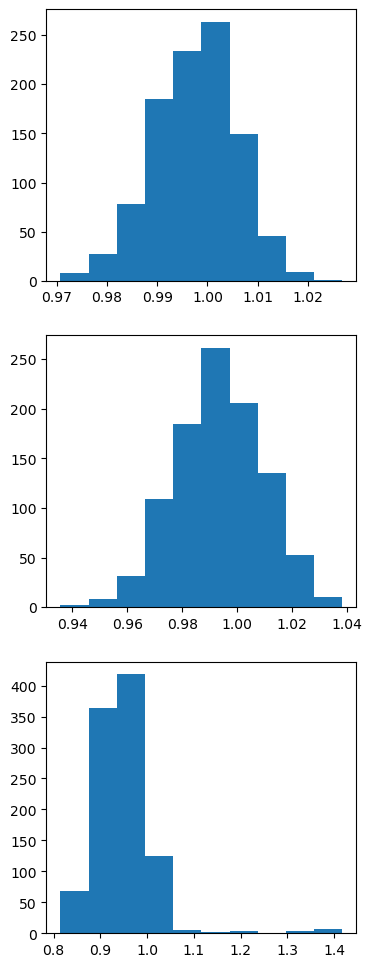

In [6]:
w, h = figaspect(3.)
_, axs = plt.subplots(3, 1, figsize=(w, h))
axs[0].hist(sigma_correct * sigma_alpha_est / sigma_alpha)
axs[1].hist(sigma_correct * sigma_beta_est / sigma_beta)
axs[2].hist(sigma_correct * sigma_tau_est / sigma_tau)
plt.show()